Importing the data

In [1]:
import pandas as pd
data = pd.read_csv('Final_df.csv')

Data Pre-Processing

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

data_copy = data
data_types = data_copy.dtypes

print(data.head(2))

   region  price manufacturer           model condition    cylinders fuel  \
0  others  33590          gmc          others      good  8 cylinders  gas   
1  others  22590    chevrolet  silverado 1500      good  8 cylinders  gas   

   odometer title_status transmission    drive    type paint_color  car_age  
0     57923        clean        other  unknown  pickup       white        8  
1     71229        clean        other  unknown  pickup        blue       12  


In [3]:
data_copy = data_copy.dropna(subset=['odometer', 'manufacturer', 'model'])

In [4]:
data_copy.fillna('unknown', inplace=True)

In [5]:
data_copy = data_copy.drop_duplicates()

In [6]:
manufacturer_values = data_copy['manufacturer'].value_counts()
data_copy['manufacturer'] =  data_copy['manufacturer'].apply(lambda x: x if str(x) in manufacturer_values[:20] else 'others')

In [7]:
region_values = data_copy['region'].value_counts()
data_copy['region'] = data_copy['region'].apply(lambda x: x if str(x) in region_values[:50] else 'others')
model_values = data_copy['model'].value_counts()
data_copy['model'] = data_copy['model'].apply(lambda x: x if str(x) in model_values[:50] else 'others')

In [8]:
price_percentile25 = data_copy['price'].quantile(0.25)
price_percentile75 = data_copy['price'].quantile(0.75)
price_iqr = price_percentile75 - price_percentile25
price_upper_limit = price_percentile75 + 1.5 * price_iqr
price_lower_limit = data_copy['price'].quantile(0.15)
new_df = data_copy[(data_copy['price'] < price_upper_limit) & (data_copy['price'] > price_lower_limit)]
odometer_percentile75 = data_copy['odometer'].quantile(0.75)
odometer_percentile25 = data_copy['odometer'].quantile(0.25)
odometer_iqr = odometer_percentile75 - odometer_percentile25
odometer_upper_limit = odometer_percentile75 + 1.5 * odometer_iqr
odometer_lower_limit = data_copy['odometer'].quantile(0.05)
new_df = new_df[(new_df['odometer'] < odometer_upper_limit) & (new_df['odometer'] > odometer_lower_limit)]

In [9]:
new_df['odometer'] = new_df['odometer'].astype(int)

<ipython-input-9-40319091b89b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['odometer'] = new_df['odometer'].astype(int)


In [11]:
final_df = new_df.copy()

Split data into Train and Test and also deal with categorical columns

In [21]:
from sklearn.model_selection import train_test_split
df_encoded = pd.get_dummies(final_df, columns=['region', 'manufacturer', 'model', 'condition', 'cylinders',
                                         'fuel', 'title_status', 'transmission', 'drive', 'type', 'paint_color'])

X = df_encoded.drop('price', axis=1)
y = df_encoded['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Running XGBoost without any distributed training and without Spark

In [23]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import time

# Convert the dataset into an optimized data structure called Dmatrix that XGBoost supports
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

# Specify parameters (there are a lot of tuning options here)
params = {
    'max_depth': 3,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'objective': 'reg:squarederror',  # regression with squared loss
    'num_boost_round': 1000  # the number of boosting rounds or trees to build
}

# Train the model
start = time.time()
bst = xgb.train(params, dtrain, num_boost_round=params['num_boost_round'])
end = time.time()
print("Training time in seconds: ")
print(end - start)

# Predict the labels of the test set
y_pred = bst.predict(dtest)

# Calculate and print the mean squared error
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"R-squared Score: {r2}")
print(f"Mean Squared Error: {mse}")


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [21:11:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)


Training time in seconds: 
31.215203523635864
R-squared Score: 0.8083241976373188
Mean Squared Error: 18415503.70010001


In [30]:
!pip install pyspark


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=c75e4fe839f973f0df881a8ba438836a55ef18537ab705e7c9e428f281c2f6b3
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


### Running XGBoost with Spark

In [58]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col
from xgboost.spark import SparkXGBRegressor
from pyspark.ml.evaluation import RegressionEvaluator
import time

# Initialize Spark Session
# spark = SparkSession.builder.appName("XGBoostRegressor").getOrCreate()
spark = SparkSession.builder \
    .appName("XGBoostRegressor") \
    .master("local[2]") \
    .config("spark.executor.cores", "2") \
    .getOrCreate()

# Load your data into a Spark DataFrame (assuming df is your pandas DataFrame)
sdf = spark.createDataFrame(df_encoded)

# Convert columns to features column (VectorAssembler is used to transform the input columns to a single vector column)
assembler = VectorAssembler(inputCols=[c for c in sdf.columns if c != 'price'], outputCol="features")
sdf_transformed = assembler.transform(sdf)

# Define the label column
sdf_transformed = sdf_transformed.withColumnRenamed("price", "label")

# Splitting the dataset into the Training set and Test set
train, test = sdf_transformed.randomSplit([0.8, 0.2], seed=42)



In [59]:
# numWorkers=2
spark_reg_estimator = SparkXGBRegressor(
    features_col="features",
    label_col="label",
    numWorkers=2,  # number of workers; adjust based on your cluster
    maxDepth=3,
    eta=0.3,
    objective='reg:squarederror',
    numRound=1000
)
# Train the model
start = time.time()
spark_model = spark_reg_estimator.fit(train)
end = time.time()
print("Training time in seconds: ", end - start)
print("===================================\n")
# Predict the labels of the test set
predictions = spark_model.transform(test)

# Evaluate the model for RMSE
evaluator_rmse = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator_rmse.evaluate(predictions)
print("Root Mean Squared Error: ", rmse)

# Evaluate the model for R-squared
evaluator_r2 = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)
print("R-squared: ", r2)


INFO:XGBoost-PySpark:Running xgboost-2.0.2 on 1 workers with
	booster params: {'objective': 'reg:squarederror', 'device': 'cpu', 'numWorkers': 2, 'maxDepth': 3, 'eta': 0.3, 'numRound': 1000, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!


Training time in seconds:  27.177735090255737

Root Mean Squared Error:  4395.464645043326
R-squared:  0.798954350515485


In [63]:
spark.conf.set("spark.sql.legacy.setCommandRejectsSparkCoreConfs","false")
num_repeat = 5
max_worker = 4


run_time, R2, RMSE = {}, {}, {}
for num_worker in range(1,max_worker+1):
  print(f"num_worker={num_worker}")
  spark.conf.set("spark.executor.cores", str(num_worker))
  run_time[num_worker] = []
  R2[num_worker] = []
  RMSE[num_worker] = []

  for _ in range(num_repeat):
    spark_reg_estimator = SparkXGBRegressor(
        features_col="features",
        label_col="label",
        numWorkers=num_worker,  # number of workers; adjust based on your cluster
        maxDepth=3,
        eta=0.3,
        objective='reg:squarederror',
        numRound=1000
    )
    # Train the model
    start = time.time()
    spark_model = spark_reg_estimator.fit(train)
    end = time.time()
    run_time[num_worker].append(end - start)
    # Predict the labels of the test set
    predictions = spark_model.transform(test)

    # Evaluate the model for RMSE
    evaluator_rmse = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
    rmse_tmp = evaluator_rmse.evaluate(predictions)
    RMSE[num_worker].append(rmse_tmp)

    # Evaluate the model for R-squared
    evaluator_r2 = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")
    r2_tmp = evaluator_r2.evaluate(predictions)
    R2[num_worker].append(r2_tmp)


num_worker=1


INFO:XGBoost-PySpark:Running xgboost-2.0.2 on 1 workers with
	booster params: {'objective': 'reg:squarederror', 'device': 'cpu', 'numWorkers': 1, 'maxDepth': 3, 'eta': 0.3, 'numRound': 1000, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.2 on 1 workers with
	booster params: {'objective': 'reg:squarederror', 'device': 'cpu', 'numWorkers': 1, 'maxDepth': 3, 'eta': 0.3, 'numRound': 1000, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.2 on 1 workers with
	booster params: {'objective': 'reg:squarederror', 'device': 'cpu', 'numWorkers': 1, 'maxDepth': 3, 'eta': 0.3, 'numRound': 1000, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': T

num_worker=2


INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.2 on 1 workers with
	booster params: {'objective': 'reg:squarederror', 'device': 'cpu', 'numWorkers': 2, 'maxDepth': 3, 'eta': 0.3, 'numRound': 1000, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.2 on 1 workers with
	booster params: {'objective': 'reg:squarederror', 'device': 'cpu', 'numWorkers': 2, 'maxDepth': 3, 'eta': 0.3, 'numRound': 1000, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.2 on 1 workers with
	booster params: {'objective': 'reg:squarederror', 'device': 'cpu', 'numWorkers': 2, 'maxDepth': 3, 'eta': 0.3, 'numRound': 1000, 'nthread': 

num_worker=3


INFO:XGBoost-PySpark:Running xgboost-2.0.2 on 1 workers with
	booster params: {'objective': 'reg:squarederror', 'device': 'cpu', 'numWorkers': 3, 'maxDepth': 3, 'eta': 0.3, 'numRound': 1000, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.2 on 1 workers with
	booster params: {'objective': 'reg:squarederror', 'device': 'cpu', 'numWorkers': 3, 'maxDepth': 3, 'eta': 0.3, 'numRound': 1000, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.2 on 1 workers with
	booster params: {'objective': 'reg:squarederror', 'device': 'cpu', 'numWorkers': 3, 'maxDepth': 3, 'eta': 0.3, 'numRound': 1000, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': T

num_worker=4


INFO:XGBoost-PySpark:Running xgboost-2.0.2 on 1 workers with
	booster params: {'objective': 'reg:squarederror', 'device': 'cpu', 'numWorkers': 4, 'maxDepth': 3, 'eta': 0.3, 'numRound': 1000, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.2 on 1 workers with
	booster params: {'objective': 'reg:squarederror', 'device': 'cpu', 'numWorkers': 4, 'maxDepth': 3, 'eta': 0.3, 'numRound': 1000, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.2 on 1 workers with
	booster params: {'objective': 'reg:squarederror', 'device': 'cpu', 'numWorkers': 4, 'maxDepth': 3, 'eta': 0.3, 'numRound': 1000, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': T

num_worker=5


INFO:XGBoost-PySpark:Running xgboost-2.0.2 on 1 workers with
	booster params: {'objective': 'reg:squarederror', 'device': 'cpu', 'numWorkers': 5, 'maxDepth': 3, 'eta': 0.3, 'numRound': 1000, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.2 on 1 workers with
	booster params: {'objective': 'reg:squarederror', 'device': 'cpu', 'numWorkers': 5, 'maxDepth': 3, 'eta': 0.3, 'numRound': 1000, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.2 on 1 workers with
	booster params: {'objective': 'reg:squarederror', 'device': 'cpu', 'numWorkers': 5, 'maxDepth': 3, 'eta': 0.3, 'numRound': 1000, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': T

num_worker=6


INFO:XGBoost-PySpark:Running xgboost-2.0.2 on 1 workers with
	booster params: {'objective': 'reg:squarederror', 'device': 'cpu', 'numWorkers': 6, 'maxDepth': 3, 'eta': 0.3, 'numRound': 1000, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.2 on 1 workers with
	booster params: {'objective': 'reg:squarederror', 'device': 'cpu', 'numWorkers': 6, 'maxDepth': 3, 'eta': 0.3, 'numRound': 1000, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.2 on 1 workers with
	booster params: {'objective': 'reg:squarederror', 'device': 'cpu', 'numWorkers': 6, 'maxDepth': 3, 'eta': 0.3, 'numRound': 1000, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': T

num_worker=7


INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.2 on 1 workers with
	booster params: {'objective': 'reg:squarederror', 'device': 'cpu', 'numWorkers': 7, 'maxDepth': 3, 'eta': 0.3, 'numRound': 1000, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.2 on 1 workers with
	booster params: {'objective': 'reg:squarederror', 'device': 'cpu', 'numWorkers': 7, 'maxDepth': 3, 'eta': 0.3, 'numRound': 1000, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.2 on 1 workers with
	booster params: {'objective': 'reg:squarederror', 'device': 'cpu', 'numWorkers': 7, 'maxDepth': 3, 'eta': 0.3, 'numRound': 1000, 'nthread': 

num_worker=8


INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.2 on 1 workers with
	booster params: {'objective': 'reg:squarederror', 'device': 'cpu', 'numWorkers': 8, 'maxDepth': 3, 'eta': 0.3, 'numRound': 1000, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.2 on 1 workers with
	booster params: {'objective': 'reg:squarederror', 'device': 'cpu', 'numWorkers': 8, 'maxDepth': 3, 'eta': 0.3, 'numRound': 1000, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.2 on 1 workers with
	booster params: {'objective': 'reg:squarederror', 'device': 'cpu', 'numWorkers': 8, 'maxDepth': 3, 'eta': 0.3, 'numRound': 1000, 'nthread': 

Text(0, 0.5, 'R Squared')

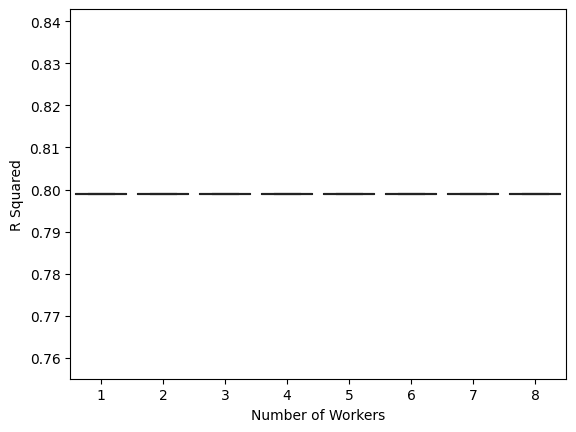

In [76]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data = []
for num_workers, times in R2.items():
    for time in times:
        data.append({'number_workers': num_workers, 'run_time': time})

df = pd.DataFrame(data)

# Create the boxplot
sns.boxplot(x='number_workers', y='run_time', data=df, palette='RdPu')

# Labeling the axes
plt.xlabel('Number of Workers')
plt.ylabel('R Squared')

In [70]:
import time
wo_run_time = []
for _ in range(5):
  # Train the model
  start = time.time()
  bst = xgb.train(params, dtrain, num_boost_round=params['num_boost_round'])
  end = time.time()
  wo_run_time.append(end - start)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:00:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:00:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:02:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "num_boost_round" } 

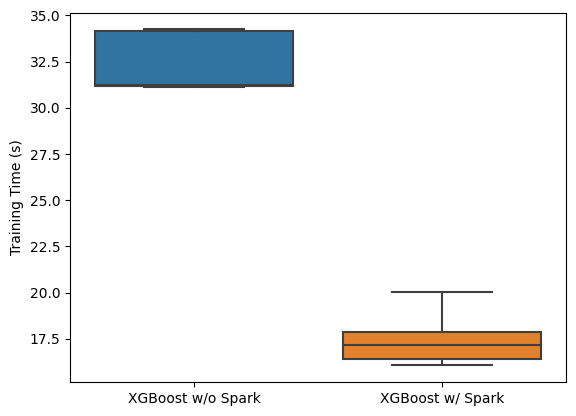

In [75]:
# Create a DataFrame from the lists
data = pd.DataFrame({'XGBoost w/o Spark': tmp1, 'XGBoost w/ Spark': tmp2})

# Melt the DataFrame to long format for Seaborn
data_long = data.melt(var_name='Model', value_name='Training Time (s)')

# Create the boxplot
sns.boxplot(x='Model', y='Training Time (s)', data=data_long)

# Labeling the axes
plt.xlabel('')
plt.ylabel('Training Time (s)')

# Display the plot
plt.show()
